<a href="https://colab.research.google.com/github/y-lims/DADS7202_Potato/blob/main/Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow tensorflow_similarity matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.6.1-py2.py3-none-any.whl.metadata (8.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.4/230.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.9 MB/s eta 0:00:00
Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.7 MB/s eta 0:00:00
  Created wheel for nmslib: filename=nmslib-2.1.1-cp310-cp310-linux_x86_64.whl size=13578479 sha256=2b7deea6757858f7df52323eaa472a8116194cce2c12eb1f3316c5cd55eb8816
  Stored in directory: /root/.cache/pip/wheels/21/1a/5d/4cc754a5b1a88405cad184b76f823897a63a8d19afcd4b9314
Successfully built nmslib


In [2]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

# from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

import os
import sys
import numpy as np
import pandas as pd
import random as rn
import sklearn
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow import keras
# from keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image, display
import matplotlib.cm as cmp
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split

import os
import numpy as np
import tensorflow as tf

import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt



Python 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]

NumPy 1.26.4

Matplotlib 3.7.1

TensorFlow 2.17.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 0 GPU(s):


In [3]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np_random_seed = 1
tf_random_seed = 1
model_name = 'vgg16'
version = 'v4'
seedno = 1
owner_name = 'l_model'


# Define a flag to check if running on Colab
on_colab = 'google.colab' in str(get_ipython())

# -----------------------------------------------------------------
np.random.seed(np_random_seed)
tf.random.set_seed(tf_random_seed)

In [4]:
if on_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = '/content/drive/My Drive/Final_Potato'
else:
    base_path = 'D:/anaconda3/envs/tfv1/00_deep_prj/Final_Potato'



Mounted at /content/drive


Processing class: Healthy


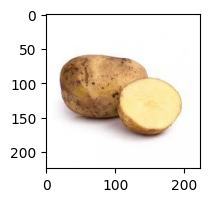

#Label : (90,)
#Un Label : (215,)
Processing class: Blackleg


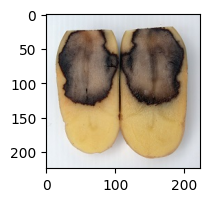

#Label : (20,)
#Un Label : (40,)
Processing class: Black Scurf


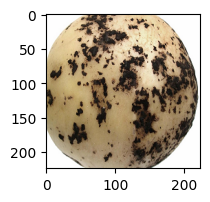

#Label : (20,)
#Un Label : (38,)
Processing class: Pink Rot


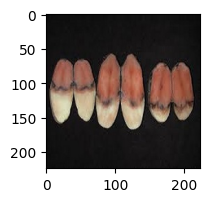

#Label : (20,)
#Un Label : (37,)
Processing class: Common Scab


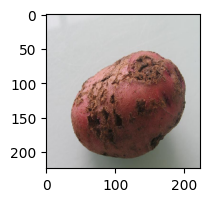

#Label : (20,)
#Un Label : (42,)
Processing class: Dry Rot


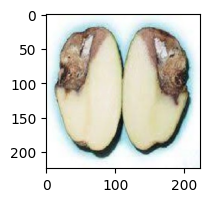

#Label : (20,)
#Un Label : (40,)
Labeled data shape: (190, 224, 224, 3) (190,)
Unlabeled data shape: (412, 224, 224, 3) (412,)


In [5]:
import numpy as np
import os
import tensorflow as tf
from sklearn.utils import shuffle

allowed_extensions = (".JPG", ".jpg", ".jpeg", ".JPEG", ".PNG", ".png")
class_mapping = {'Healthy': 0, 'Blackleg': 1, 'Black Scurf': 2, 'Pink Rot': 3, 'Common Scab': 4, 'Dry Rot': 5}

def process_dataset_with_split(folder_path, class_name, num_labeled=20):
    print(f'Processing class: {class_name}')
    x_labeled, y_labeled, z_labeled = [], [], []
    x_unlabeled, y_unlabeled, z_unlabeled = [], [], []

    # Collect files and shuffle
    file_paths = [os.path.join(folder_path, class_name, filename) for filename in os.listdir(os.path.join(folder_path, class_name))
                  if filename.endswith(allowed_extensions)]
    file_paths = shuffle(file_paths, random_state=42)  # Use random_state for consistency

    # Split data
    labeled_files = file_paths[:num_labeled]
    unlabeled_files = file_paths[num_labeled:]

    # Load images and assign to labeled or unlabeled
    for file_path in labeled_files:
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8)
        x_labeled.append(img_array)
        y_labeled.append(class_mapping[class_name])

    for file_path in unlabeled_files:
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8)
        x_unlabeled.append(img_array)
        y_unlabeled.append(class_mapping[class_name])

    return (np.array(x_labeled), np.array(y_labeled)), (np.array(x_unlabeled), np.array(y_unlabeled))

# Example usage for loading and splitting data
folder_path = '/content/drive/My Drive/Final_Potato/train_data/archive/'
x_labeled, y_labeled, x_unlabeled, y_unlabeled = [], [], [], []

for class_name in class_mapping.keys():
    if class_name == 'Healthy':
        num_labeled = 90
    else:
        num_labeled = 20
    (x_l, y_l), (x_u, y_u) = process_dataset_with_split(folder_path, class_name,  num_labeled)
    plt.figure(figsize = (2,2))
    plt.imshow(x_l[0])
    plt.show()
    print('#Label :', y_l.shape)
    print('#Un Label :', y_u.shape)
    print('====================================================')

    x_labeled.append(x_l)
    y_labeled.append(y_l)
    x_unlabeled.append(x_u)
    y_unlabeled.append(y_u)

# Concatenate arrays from all classes
x_labeled = np.concatenate(x_labeled, axis=0)
y_labeled = np.concatenate(y_labeled, axis=0)
x_unlabeled = np.concatenate(x_unlabeled, axis=0)
y_unlabeled = np.concatenate(y_unlabeled, axis=0)

print('Labeled data shape:', x_labeled.shape, y_labeled.shape)
print('Unlabeled data shape:', x_unlabeled.shape, y_unlabeled.shape)


In [13]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow_similarity.layers import MetricEmbedding
from tensorflow_similarity.losses import CircleLoss
from tensorflow_similarity.models import SimilarityModel
from tensorflow_similarity.samplers import MultiShotMemorySampler
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance

# Load datasets
def load_datasets():
    # Replace with actual data loading code
    # Example: (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
    train_images = np.random.rand(100, 600, 600, 3)  # Random data
    train_labels = np.random.randint(0, 10, 100)     # Random labels
    test_images = np.random.rand(20, 600, 600, 3)    # Random data
    test_labels = np.random.randint(0, 10, 20)       # Random labels
    return (train_images, train_labels), (test_images, test_labels)

(train_images, train_labels), (test_images, test_labels) = load_datasets()

# Define the EfficientNet B7 model
input_shape = (600, 600, 3)
base_model = EfficientNetB7(include_top=False, input_shape=input_shape, weights='imagenet')
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(512, activation='relu')(x)
embeddings = MetricEmbedding(512)(x)

model = SimilarityModel(inputs=base_model.input, outputs=embeddings)
model.compile(optimizer='adam', loss=CircleLoss(reduction='sum_over_batch_size'))

# Train the model
classes_per_batch = min(6, len(np.unique(train_labels)))  # Ensure classes_per_batch does not exceed number of classes
sampler = MultiShotMemorySampler(train_images, train_labels, classes_per_batch=classes_per_batch)
history = model.fit(sampler, epochs=40, steps_per_epoch=1000, validation_data=(test_images, test_labels))

# Extract embeddings for the training set
train_embeddings = model.predict(train_images)

# Extract embeddings for the test set
test_embeddings = model.predict(test_images)

# Query an example image and get similar images
query_image = test_images[0]
query_embedding = test_embeddings[0]
query_label = test_labels[0]

# Calculate distances to all training embeddings
distances = distance.cdist([query_embedding], train_embeddings, 'cosine')[0]

# Get the top 20 similar images
top_k_indices = np.argsort(distances)[:20]
similar_labels = train_labels[top_k_indices]

# Print the results
print(f"Query image label: {query_label}")
print(f"Top 20 similar images and their distances: {list(zip(similar_labels, distances[top_k_indices]))}")

# Calculate evaluation metrics
y_true = [query_label] * len(similar_labels)
y_pred = similar_labels

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Visualize the results
plt.figure(figsize=(10, 10))
plt.subplot(5, 5, 1)
plt.imshow(query_image)
plt.title(f"Query: {query_label}")
plt.axis('off')

for i, index in enumerate(top_k_indices):
    image = train_images[index]
    label = train_labels[index]
    distance_val = distances[index]
    plt.subplot(5, 5, i+2)
    plt.imshow(image)
    plt.title(f"Label: {label}, Dist: {distance_val:.2f}")
    plt.axis('off')

plt.show()


Distance metric automatically set to cosine use the distance arg to override.

The initial batch size is 20 (10 classes * 2 examples per class) with 0 augmentations


filtering examples:   0%|          | 0/100 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/100 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/40


KeyboardInterrupt: 